# In this notebook im implmenting an image segmentation model on data-science-bowl-2018 data from kaggle
## 1. In this notebook im implmenting the network to look at fine details only [no usage of transposed convolutions] `i will implment it with transposed conv in another notebook`

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

# Grab the data from kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c data-science-bowl-2018
! unzip data-science-bowl-2018.zip

# Create a folder named 'train_data' and extract stage1_train.zip into it
! mkdir train_data
! unzip -q stage1_train.zip -d train_data


 98% 352M/358M [00:01<00:00, 234MB/s]
100% 358M/358M [00:01<00:00, 255MB/s]
Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


# * Grab utils file

In [ ]:
import requests

def save_url_content_as_py(url, file_name):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for HTTP errors

        with open(file_name, 'w') as file:
            file.write(response.text)

        print(f"Content from {url} saved to {file_name} successfully.")
    except requests.RequestException as e:
        print(f"Error fetching content from {url}: {e}")

# Example usage:
url = 'https://raw.githubusercontent.com/Amr-Abdellatif/Fingerprint-recognition-using-Autoencoders/master/utils.py'  # Replace with your desired URL
file_name = "utils.py"  # Replace with your desired file name

save_url_content_as_py(url, file_name)



Content from https://raw.githubusercontent.com/Amr-Abdellatif/Fingerprint-recognition-using-Autoencoders/master/utils.py saved to utils.py successfully.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import os
import random
import torch
from torchvision import transforms
from PIL import Image
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
import imageio.v2
from utils import View
from utils import train_network

In [ ]:
# Creating an iterator to go get all path in that directory
paths = glob("/content/train_data/*")

In [ ]:
print(len(paths))

670


Create a class to combine all masks images into a single image as they are seperated originally

In [ ]:
class datasciencebowl(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""
    def __init__(self, paths):
        """paths: a list of paths to every image folder in the dataset"""
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        img_path = glob(self.paths[idx] + "/images/*")[0]
        #but there are multiple mask images in each mask path
        mask_imgs = glob(self.paths[idx] + "/masks/*")
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        img = imageio.v2.imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        img = img/255.0

        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        masks = [imageio.v2.imread(f)/255.0 for f in mask_imgs]

        #Since we want to do simple segmentation, we will create one final mask that contains _all_ nuclei pixels from _every_ mask
        final_mask = np.zeros(masks[0].shape)
        for m in masks:
            final_mask = np.logical_or(final_mask, m)
        final_mask = final_mask.astype(np.float32)

        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        img = F.interpolate(img.unsqueeze(0), (256, 256))
        final_mask = F.interpolate(final_mask.unsqueeze(0), (244, 244))
        #Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]


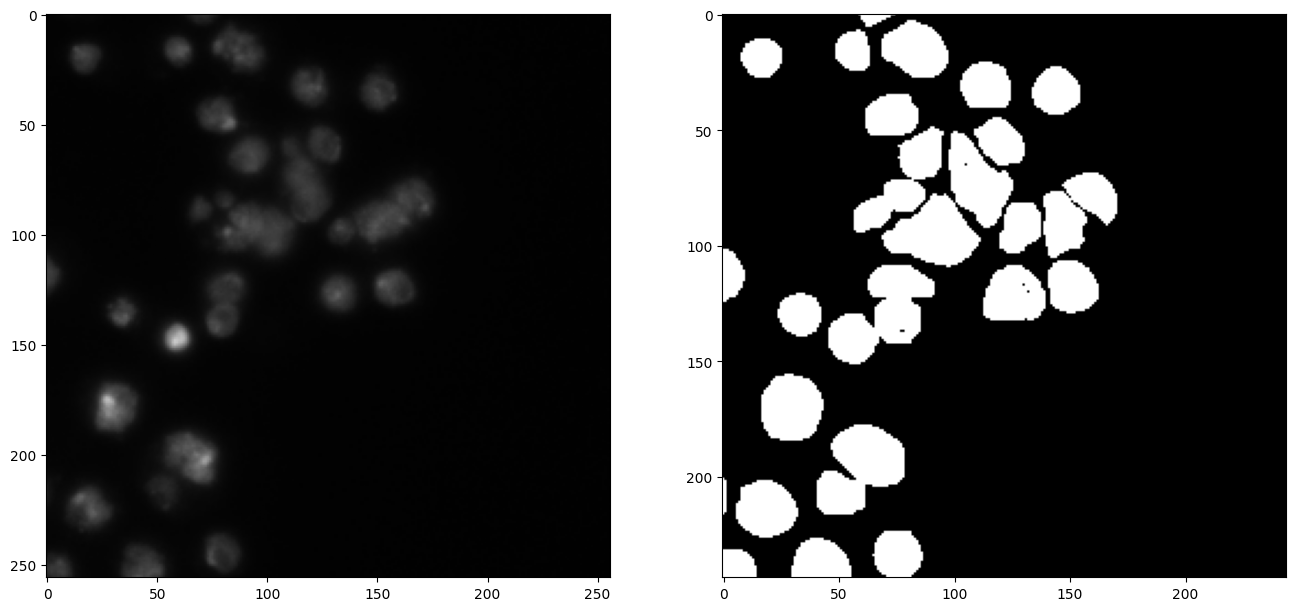

In [ ]:
#Create the Dataset class object
dsb_data = datasciencebowl(paths)

plt.figure(figsize=(16,10))
#Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1,2,0).numpy())
#Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray')



torch.Size([1, 244, 244])


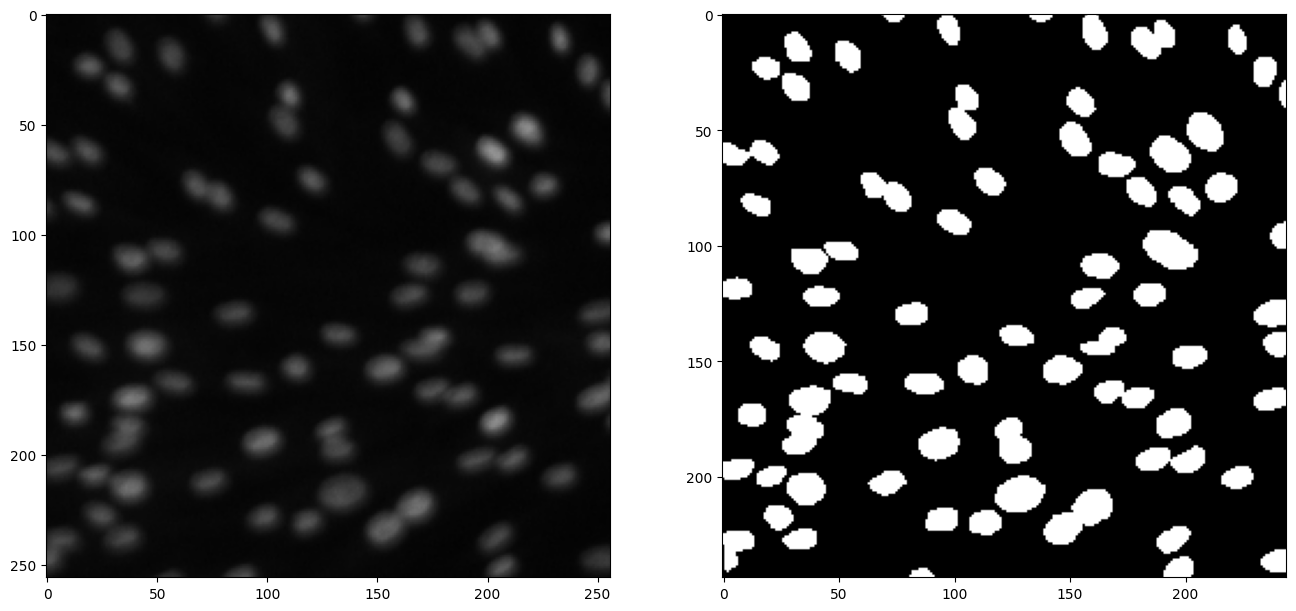

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[2][0].permute(1,2,0).numpy())
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[2][1].numpy()[0,:], cmap='gray')
print(dsb_data[2][1].shape) # look at the shape of the image


In [ ]:
len(dsb_data)

670

In [ ]:
train_split , test_split = torch.utils.data.random_split(dsb_data,[500,len(dsb_data)-500])

In [ ]:
len(train_split) , len(test_split)

(500, 170)

In [ ]:
train_split[0][0].shape , test_split[0][0].shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [ ]:
train_seg_loader = DataLoader(train_split,batch_size=8,shuffle=True)
test_seg_loader = DataLoader(test_split,batch_size=8)

In [ ]:
# specify hyperparameters
C = 3 # since original images are 3 channels RGB
n_filters = 32 # the output filters
loss_function = nn.BCEWithLogitsLoss() # binarycross entropy because in every image we have two classes [nuclei / background ]

In [ ]:
def cnnlayer(in_filters,out_filters,kernel_size=3):
  """
  in_filters: how many channels are in the input to this layer
  out_filters: how many channels should this layer output
  kernel_size: how large should the filters of this layer be
  """
  padding = kernel_size //2
  return nn.Sequential(
      nn.Conv2d(in_filters,out_filters,kernel_size),
      nn.BatchNorm2d(out_filters),
      nn.LeakyReLU()
    )

In [ ]:
segmentation_model = nn.Sequential(
    cnnlayer(C,n_filters),
    *[cnnlayer(n_filters,n_filters) for _ in range(5)],
    nn.Conv2d(n_filters,1,(3,3),padding=1)
  )

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
test_split[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
seg_results = train_network(segmentation_model,
                            loss_func=loss_function,
                            train_loader=train_seg_loader,
                            val_loader=test_seg_loader,
                            epochs=1,
                            device=device)

In [ ]:
seg_results

In [ ]:
index = 6
with torch.inference_mode():
  logits = segmentation_model(test_split[index][0]. unsqueeze(0).to(device))[0].cpu()
  pred = torch.sigmoid(logits) >= 0.5
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(),cmap='gray') # the original image
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') # plot test image
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0,:], cmap='gray') # plot the prediction with threshold 0.5